# Running a Multi-Step Workflow on a Remote System 

## Aim

This notebook demonstrates how we can connect and execute tasks in a workflow. In this example; we get an initail structure, generate scaled structures, run `Quantum Espresso` and then split structures into `test`, `train` and `valid` files.

### Setup

For this tutorial we will assume you have: 
<ul>
        <li>An AiiDA profile setup</li>
        <li>An external computer setup in AiiDA with a quantum espresso code</li>
                <ul>
                        <li>A tutorial can be found in <a href="../aiida_setup/setup-external-computer.ipynb"><code>../aiida_setup/setup-external-computer.ipynb</code></a></li>
                </ul>
        <li>The <code>aiida-quantumespresso</code>, <code>aiida-pseudo</code> and <code>fpsample</code> extra dependancies installed</li>
        <li>Pseudopotentails SSSP installed</li>
                <ul>
                        <li>They can be installed with: <code>aiida-pseudo install sssp</code></li>
                </ul>

</ul>

The initial setup is very similar to the other tutorials, such as `singlepoint.ipynb`, which goes into more detail about what each step is doing

Load the aiida profile, model and code:

In [1]:
from aiida import load_profile  
load_profile()

Profile<uuid='c677ac2b24bc40178ad9f1681fc23d0a' name='presto'>

In [2]:
from aiida.orm import load_code
from aiida_mlip.data.model import ModelData

uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp")

janus_code = load_code("janus@localhost")
qe_code = load_code("qe@localhost")

First, we set up the scaling task. It takes a `StructureData` object as input and produces scaled `atoms`. The number of generated atomic structures is determined by the `num_structs` parameter. The task returns a dictionary containing these structures.

In [3]:
from aiida_workgraph import WorkGraph, task
import numpy as np
from aiida.orm import Int, Float, List, Dict, SinglefileData,InstalledCode, KpointsData, StructureData, load_group

from random import shuffle

@task.calcfunction(outputs=["scaled_structures"])
def create_scales(
    min_v: Float,
    max_v:Float,
    num_structs: Int,
    structure: StructureData
): 
    lattice_scalars = np.cbrt(np.linspace(min_v.value, max_v.value, num_structs.value))
    scaled_structures = {}

    atom = structure.get_ase()
    cell = atom.get_cell()

    for i, s in enumerate(lattice_scalars):
        scaled_atom = atom.copy()
        scaled_atom.set_cell(cell * s, scale_atoms=True)
        struct_data = f"struct{i}"
        scaled_structures[struct_data] = StructureData(ase=scaled_atom)


    return {
        "scaled_structures": scaled_structures
    }

Before setting up the work graph, we first configure the `Quantum Espresso (QE)` task by defining the code and input parameters. Since we need to run QE on multiple structures, we create multiple `PwCalculation` tasks dynamically within the same task using `get_current_graph()`. This allows us to run QE for each structure and return the corresponding `TrajectoryData` and parameters for each.

In [4]:
from aiida_quantumespresso.calculations.pw import PwCalculation
from aiida_workgraph.manager import get_current_graph

@task.graph(outputs=["structures"])
def qe(
    code: InstalledCode,
    kpoints_mesh: List,
    task_metadata: Dict,
    **scaled_structures,
    ):

    wg = get_current_graph()

    kpoints = KpointsData()
    kpoints.set_kpoints_mesh(kpoints_mesh)

    pseudo_family = load_group('SSSP/1.3/PBE/efficiency')
    
    output_structures = {}

    for i, structs in scaled_structures.items():
        
        structure = StructureData(ase=structs.get_ase())
        pseudos = pseudo_family.get_pseudos(structure=structure)

        ecutwfc, ecutrho = pseudo_family.get_recommended_cutoffs(
            structure=structure,
            unit='Ry',
        )

        pw_params = {
            "CONTROL": {
                "calculation": "scf",
                'tprnfor': True,
                'tstress': True,
            },
            "SYSTEM": {
                "ecutwfc": ecutwfc,
                "ecutrho": ecutrho,
            },
        }
        
        qe_task = wg.add_task(
            PwCalculation,
            code=code,
            parameters=pw_params,
            kpoints=kpoints,
            pseudos=pseudos,
            metadata=task_metadata.value,
            structure=structure,
        )

        output_structures[f"struct{i}"] = {
                "trajectory":qe_task.outputs.output_trajectory,
                "parameters": qe_task.outputs.output_parameters
            }
        
        wg.update_ctx({
            "structures": output_structures
        })

    return {
        "structures": wg.ctx.structures,
    }

The `create_train_files` extracts the attributes needed from each structure and splits structures into random test, train and validation files. This task returns `SinglefileData` instances of `test_file`, `train_file` and `valid_file`.

In [5]:
from pathlib import Path
from ase.io import read, write
from ase import units
import tempfile

@task.calcfunction(outputs=["test_file", "train_file", "valid_file"])
def create_train_files(**structures):
    
    structures_stack = list(structures.keys())
    shuffle(structures_stack)
    
    n = len(structures_stack)
    i1 = int(n*0.7)
    i2 = int(n*0.9)

    training_split = {
        "test":structures_stack[:i1],
        "train":structures_stack[i1:i2],
        "valid":structures_stack[i2:]
    }

    files = {}

    for split, split_structures in training_split.items():
        tmpfile = tempfile.NamedTemporaryFile(suffix=f"{split}.extxyz")
        for struct in split_structures:

            trajectory = structures[struct]["trajectory"]
            fileStructure = trajectory.get_structure(index=0)
            fileAtoms = fileStructure.get_ase()

            stress = trajectory.arrays["stress"][0]
            converted_stress = stress * units.GPa
            fileAtoms.info["qe_stress"] = converted_stress

            fileAtoms.info["units"] = {"energy": "eV","forces": "ev/Ang","stress": "ev/Ang^3"}
            fileAtoms.set_array("qe_forces", trajectory.arrays["forces"][0])

            parameters = structures[struct]["parameters"]
            fileParams = parameters.get_dict()
            fileAtoms.info["qe_energy"] = fileParams["energy"]
            
            write(Path(tmpfile.name), fileAtoms, append=True)

        files[f"{split}_file"] = SinglefileData(tmpfile)
    
    for filename, file in files.items():
        with file.as_path() as path:
            num_structs = len(read(path, index=":"))
        print(f"{filename} has {num_structs} structures")

    return{
        "test_file": files["test_file"],
        "train_file": files["train_file"],
        "valid_file": files["valid_file"]
    }


Setup the QE inputs these variables can be changed to your configuration.

In [6]:
qe_inputs = {
    "task_metadata": Dict({
            "options": {
                "resources": {
                    "tot_num_mpiprocs":1,
                    'num_mpiprocs_per_machine':1,
                    'num_cores_per_mpiproc':8,
                },
                "max_wallclock_seconds": 3600,
                "queue_name": "scarf",
                "qos": "scarf",
                "environment_variables": {},
                "withmpi": True,
                "prepend_text": """
                """,
                "append_text": "",
            },
    }),
    "kpoints_mesh": List([1, 1, 1]),
    "code": qe_code,
}

In [7]:
from ase.build import bulk

with WorkGraph("EOS_workflow") as wg:

    initial_structure = StructureData(ase=bulk("NaCl", "rocksalt", 5.63))

    scales_task = wg.add_task(
        create_scales,
        min_v=0.95,
        max_v=1.05,
        num_structs=12,
        structure=initial_structure
    )

    qe_task = wg.add_task(
        qe,
        **qe_inputs,
        scaled_structures=scales_task.outputs.scaled_structures
    )
    
    train_task = wg.add_task(
        create_train_files,
        structures=qe_task.outputs.structures
    )
 

In [8]:
wg

In [9]:
wg.run()

11/25/2025 01:48:47 PM <37567> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.12.1 is not supported and will cause unexpected problems!
11/25/2025 01:48:47 PM <37567> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
11/25/2025 01:48:47 PM <37567> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
11/25/2025 01:48:47 PM <37567> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2255|WorkGraphEngine|continue_workgraph]: tasks ready to run: create_scales
11/25/2025 01:48:47 PM <37567> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2255|WorkGraphEngine|update_task_state]: Task: create_scales, type: CALCFUNCTION, finished.
11/25/2025 01:48:47 PM <37567> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2255|WorkGraphEngine|continue_workgraph]: tasks ready to run: qe
11/25/2025 01:48:48 PM <37567> aiida

test_file has 8 structures
train_file has 2 structures
valid_file has 2 structures


{}

In [10]:
test_file = wg.tasks.create_train_files.outputs.test_file.value
train_file = wg.tasks.create_train_files.outputs.train_file.value
valid_file = wg.tasks.create_train_files.outputs.valid_file.value

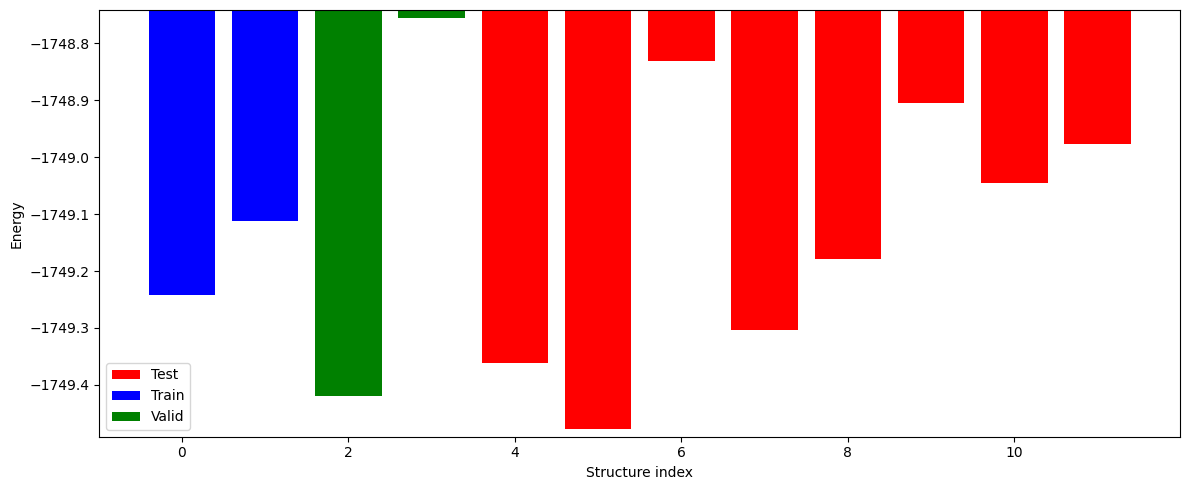

In [ ]:
from ase.io import iread
import matplotlib.pyplot as plt


with test_file.as_path() as path:
        test_energy = np.array([struct.info['qe_energy'] for struct in iread(path, index=':')])
with train_file.as_path() as path:
        train_energy = np.array([struct.info['qe_energy'] for struct in iread(path, index=':')])
with valid_file.as_path() as path:
        valid_energy = np.array([struct.info['qe_energy'] for struct in iread(path, index=':')])

train_x = np.arange(len(train_energy))
valid_x = np.arange(len(valid_energy)) + len(train_energy)
test_x  = np.arange(len(test_energy))  + len(train_energy) + len(valid_energy)

# Create plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(test_x,  test_energy,  color="red",  label="Test")
ax.bar(train_x, train_energy, color="blue", label="Train")
ax.bar(valid_x, valid_energy, color="green", label="Valid")


# Compute zoom window
y_min = min(train_energy.min(), valid_energy.min(), test_energy.min())
y_max = max(train_energy.max(), valid_energy.max(), test_energy.max())

# Shrink range by ~95% so differences are visible
padding = 0.02 * (y_max - y_min)
ax.set_ylim(y_min - padding, y_max + padding)

ax.set_ylabel("Energy")
ax.set_xlabel("Structures")
ax.legend()

plt.tight_layout()
plt.show()